<img src="https://www.iscte-iul.pt/assets/images/logo_iscte_detailed.svg" style="width: 450px;margin-top:30px;" align ="center">

<div style= "font-size: 35px;  margin-top:40px; font-weight:bold; font-family: 'Avenir Next LT Pro', sans-serif;"><center>User Clustering: <strong>E-Commerce</strong></center></div>
<div style= "font-size: 30px; font-weight:bold; font-family: 'Avenir Next LT Pro', sans-serif;"><center>Organizing all variables and data to the models phase</center></div>

<div style= "font-size: 27px;font-weight:bold;line-height: 1.1; margin-top:40px; font-family: 'Avenir Next LT Pro', sans-serif;"><center>Processamento e Modelação de Big Data 2024/2025</center></div> <br>

   <div style= "font-size: 20px;font-weight:bold; font-family: 'Avenir Next LT Pro', sans-serif;"><center> Grupo 7:</center></div>
   <div><center> Diogo Freitas | 104841 </center></div>
   <div><center> João Francisco Botas | 104782 </center></div>
   <div><center> Miguel Gonçalves | 105944 </center></div>
   <div><center> Ricardo Galvão | 105285 </center></div>

In [1]:
# Importações Básicas
import pyspark
import pandas as pd
from pyspark.sql import SparkSession, Row
import pyspark.sql.functions as F
from pyspark.sql.functions import split, isnan, col, isnull, avg, count, round
from pyspark.sql.types import (
    StructType, StructField,
    StringType, LongType, DoubleType, TimestampType
)


# Create a Spark session
spark = SparkSession.builder \
    .appName("PMBD") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

In [2]:
# Criação da Sessão
spark = SparkSession.builder.appName("Projeto").getOrCreate()

# Leitura de dados
data_dir = '../data/'
file_ec = data_dir + 'user_df.parquet'

# Carrega as primeiras 10.000 linhas
ec_user = spark.read.parquet(file_ec)

In [3]:
ec_user.repartition(36, "total_views")

DataFrame[user_id: bigint, average_price: double, total_views: bigint, electronics: bigint, appliances: bigint, furniture: bigint, computers: bigint, apparel: bigint, construction: bigint, auto: bigint, kids: bigint, sport: bigint, accessories: bigint]

In [4]:
ec_user.show()

+---------+-------------+-----------+-----------+----------+---------+---------+-------+------------+----+----+-----+-----------+
|  user_id|average_price|total_views|electronics|appliances|furniture|computers|apparel|construction|auto|kids|sport|accessories|
+---------+-------------+-----------+-----------+----------+---------+---------+-------+------------+----+----+-----+-----------+
|515761354|       141.55|          3|          0|         3|        0|        0|      0|           0|   0|   0|    0|          0|
|565865924|       949.47|          1|          1|         0|        0|        0|      0|           0|   0|   0|    0|          0|
|527322328|      197.797|          7|          0|         7|        0|        0|      0|           0|   0|   0|    0|          0|
|553334193|       172.23|          1|          1|         0|        0|        0|      0|           0|   0|   0|    0|          0|
|565921426|       165.26|          1|          1|         0|        0|        0|      0|  

## KMeans Clustering

In [5]:
feature_cols = ec_user.columns
feature_cols.pop(0)

'user_id'

In [6]:
from pyspark.ml.feature import VectorAssembler, MaxAbsScaler

In [7]:
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features_prescale")
client_features = assembler.transform(ec_user)

scaler = MaxAbsScaler(inputCol="features_prescale", outputCol="features")
client_features = scaler.fit(client_features).transform(client_features).repartition(36, "total_views")

In [8]:
client_features.show()

+---------+-------------+-----------+-----------+----------+---------+---------+-------+------------+----+----+-----+-----------+--------------------+--------------------+
|  user_id|average_price|total_views|electronics|appliances|furniture|computers|apparel|construction|auto|kids|sport|accessories|   features_prescale|            features|
+---------+-------------+-----------+-----------+----------+---------+---------+-------+------------+----+----+-----+-----------+--------------------+--------------------+
|545220871|       86.871|         32|          0|         0|        0|        0|     32|           0|   0|   0|    0|          0|(12,[0,1,6],[86.8...|(12,[0,1,6],[0.03...|
|520088904|      444.383|         17|          9|         0|        0|        8|      0|           0|   0|   0|    0|          0|(12,[0,1,2,5],[44...|(12,[0,1,2,5],[0....|
|520772685|      432.336|         17|          0|         0|        0|       17|      0|           0|   0|   0|    0|          0|(12,[0,1,5]

In [9]:
from pyspark.ml.clustering import KMeans, GaussianMixture, BisectingKMeans
from pyspark.ml.evaluation import ClusteringEvaluator

In [10]:
silhouette_score=dict()
models = [KMeans(), GaussianMixture(), BisectingKMeans()]
  
evaluator = ClusteringEvaluator(predictionCol='prediction', 
                                featuresCol='features',  
                                metricName='silhouette',  
                                distanceMeasure='squaredEuclidean') 

for model in models:
    print(f"Now iterating over {model}")
    silhouette_score[str(model)] = []
    model = model.setFeaturesCol('features').setSeed(42)
    for i in range(2,10): 
        model = model.setK(i)
        fitted_model=model.fit(client_features) 
        predictions=fitted_model.transform(client_features) 
        score=evaluator.evaluate(predictions) 
        silhouette_score[str(model)].append(score) 
        print('Silhouette Score for k =',i,'is',score)
    print()

Now iterating over KMeans_97efaabe289e
Silhouette Score for k = 2 is 0.6332562251720765
Silhouette Score for k = 3 is 0.6541078829214935
Silhouette Score for k = 4 is 0.6578772705019165
Silhouette Score for k = 5 is 0.6832675516756834
Silhouette Score for k = 6 is 0.673717998010439
Silhouette Score for k = 7 is 0.6991704406708703
Silhouette Score for k = 8 is 0.46399883734340136
Silhouette Score for k = 9 is 0.49735015994274084

Now iterating over GaussianMixture_62ca6bec250c
Silhouette Score for k = 2 is 0.498383887353929
Silhouette Score for k = 3 is 0.07164335435021275
Silhouette Score for k = 4 is -0.1367559506306904
Silhouette Score for k = 5 is -0.04349358297388392
Silhouette Score for k = 6 is -0.1537059095545994
Silhouette Score for k = 7 is -0.02160406317786883
Silhouette Score for k = 8 is -0.10653863285216193
Silhouette Score for k = 9 is -0.09070184778650338

Now iterating over BisectingKMeans_23e4ac5d221d
Silhouette Score for k = 2 is 0.6332562251720765
Silhouette Score fo

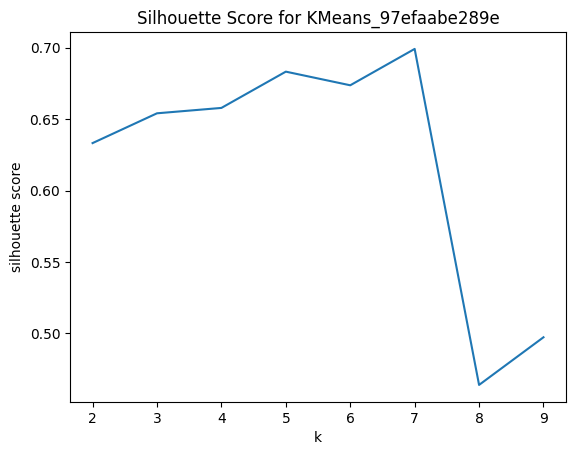

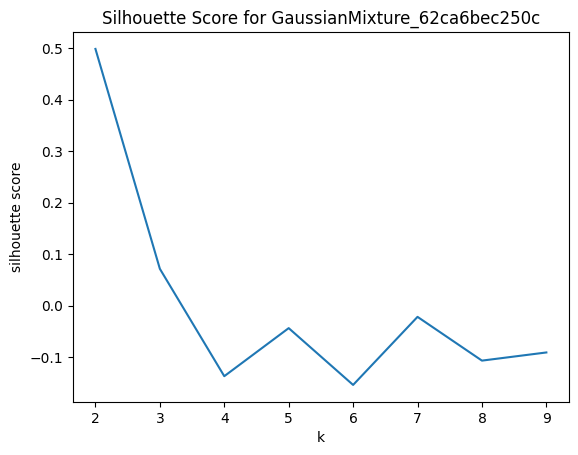

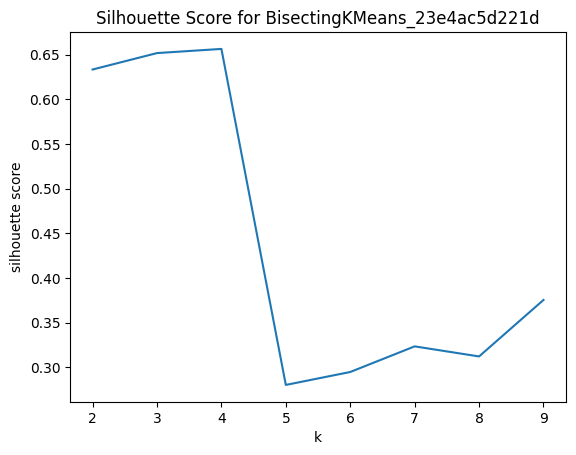

In [11]:
import matplotlib.pyplot as plt 
  
for model in models:
    plt.plot(range(2,10),silhouette_score[str(model)]) 
    plt.xlabel('k') 
    plt.ylabel('silhouette score') 
    plt.title(f'Silhouette Score for {model}') 
    plt.show()

In [12]:
print(models)

[KMeans_97efaabe289e, GaussianMixture_62ca6bec250c, BisectingKMeans_23e4ac5d221d]


In [19]:
chosen_model = models[0]
optimal_k = silhouette_score[str(chosen_model)].index(max(silhouette_score[str(chosen_model)])) + 2

In [20]:
# Trains a k-means model.
model = chosen_model.setSeed(42).setFeaturesCol("features").setK(optimal_k)
fitted_model = model.fit(client_features)

# Make predictions
predictions = fitted_model.transform(client_features)

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

# Shows the result.
centers = fitted_model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Silhouette with squared euclidean distance = 0.6991704406708703
Cluster Centers: 
[0.10047155 0.04885067 0.02629027 0.00980424 0.01033058 0.00594535
 0.00571687 0.0051683  0.00841064 0.00477737 0.00049474 0.00082825]
[4.74756702e-01 4.90366507e-02 5.40986791e-02 2.35779546e-03
 4.27350427e-03 7.38150738e-03 9.93838203e-05 3.05250305e-04
 0.00000000e+00 0.00000000e+00 1.13960114e-03 0.00000000e+00]
[0.07153476 0.15254237 0.00454545 0.         0.         0.
 0.         0.55238095 0.02666667 0.         0.         0.02380952]
[0.31123822 0.21104429 0.02346041 0.         0.00219941 0.51466276
 0.         0.         0.         0.         0.         0.        ]
[0.32842018 0.17917676 0.05519481 0.         0.         0.
 0.00332226 0.         0.         0.         0.53333333 0.        ]
[0.09779972 0.46720707 0.01778656 0.22113943 0.1027668  0.
 0.17087968 0.         0.         0.04347826 0.         0.04347826]
[0.15073349 0.24942739 0.3215602  0.00256291 0.002457   0.0012285
 0.00219987 0.001

In [21]:
predictions.groupBy("prediction").count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         5|   23|
|         6|   74|
|         3|   31|
|         1|  234|
|         0| 1078|
|         4|    7|
|         2|   15|
+----------+-----+



In [22]:
cluster_profiles = predictions.groupBy("prediction").mean()

In [23]:
for c in cluster_profiles.columns:
    cluster_profiles = cluster_profiles.withColumn(c, F.round(c, 2))

In [24]:
cluster_profiles.show()

+----------+--------------+------------------+----------------+----------------+---------------+--------------+--------------+------------+-----------------+---------+---------+----------+----------------+---------------+
|prediction|  avg(user_id)|avg(average_price)|avg(total_views)|avg(electronics)|avg(appliances)|avg(furniture)|avg(computers)|avg(apparel)|avg(construction)|avg(auto)|avg(kids)|avg(sport)|avg(accessories)|avg(prediction)|
+----------+--------------+------------------+----------------+----------------+---------------+--------------+--------------+------------+-----------------+---------+---------+----------+----------------+---------------+
|         5|5.4035663474E8|            219.02|           27.57|            0.78|          12.83|          4.52|           0.0|        7.35|              0.0|      0.0|     0.87|       0.0|            1.22|            5.0|
|         6|5.3902862628E8|            337.56|           14.72|           14.15|           0.15|          0.11| 